这里讨论Texture Synthesis by Non-parametric Sampling提到的“非参”纹理合成方法，基本就是给定一个要决定其像素值的点，去样本图片
（一般也是欲合成图片的一部分）去找有类似上下文环境的点，差别小于阈值的参与采样。原实现好像是直接采一个既存的值，也可以考虑把那些
当作一个条件分布的样本估计其参数。

为了简化我们下面只考虑向右“推”的情况，所以样本只用左边的，像素就从以最低差别算的10%相对误差计入样本。

In [1]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

In [143]:
img_full = (imageio.imread('ct.png', pilmode='L') / 255 - 0.5) *2
m_full,n_full = img_full.shape
img = img_full[:,:n_full//2]
m,n = img.shape

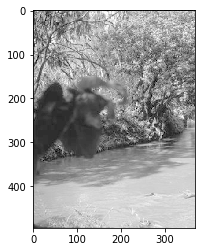

In [144]:
plt.imshow(img, cmap='gray')
plt.show()

In [145]:
img.dtype, img.shape

(dtype('float64'), (495, 368))

In [146]:
from scipy.ndimage import correlate,convolve

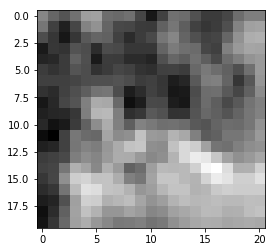

In [147]:
r = 20
w = img[m//2-r//2 : m//2+r//2 , -1-r:]
plt.imshow(w, cmap='gray')

In [148]:
correlate(img, w).shape

(495, 368)

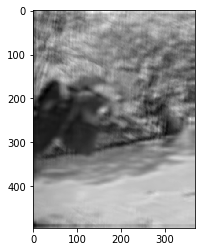

In [149]:
plt.imshow(correlate(img, w), cmap='gray')

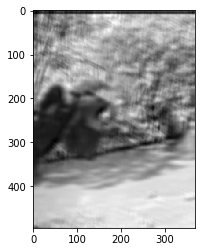

In [150]:
plt.imshow(convolve(img, w), cmap='gray')

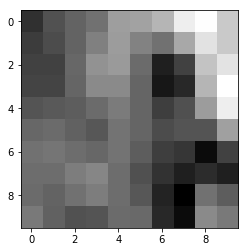

In [151]:
r = 10
w = img[m//2-r//2 : m//2+r//2 , n//2:n//2+r]
plt.imshow(w, cmap='gray')

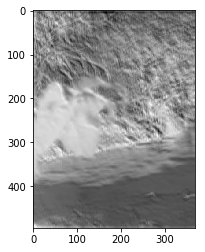

In [152]:
plt.imshow(correlate(img, w), cmap='gray')

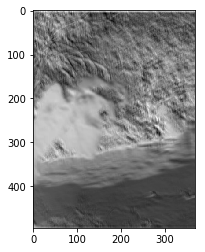

In [153]:
plt.imshow(convolve(img, w), cmap='gray')

In [155]:
corr = correlate(img, w)

In [160]:
np.sum(corr/corr.max() > 0.9)

27

In [167]:
np.random.choice(corr[corr/corr.max() > 0.9]),np.random.choice(corr[corr/corr.max() > 0.9])

(6.036755094194541, 6.038754325259516)

In [191]:
r = 10
p = 0.9
extend = 20
x = np.c_[img, np.empty([m, extend], dtype=img.dtype)]

for j in range(n,n+extend):
    #col = np.empty(n)
    for i in range(n):
        w = x[max(i-r//2, 0) : min(i+r//2, m-1) , j-r:j]
        corr = correlate(x[:,:j], w)
        x[i,j] = np.random.choice(x[:,:j][(corr+1e-6)/(corr.max()+1e-6) p])

IndexError: index 388 is out of bounds for axis 1 with size 388

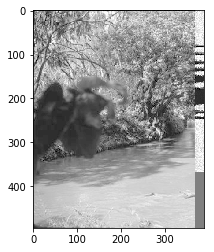

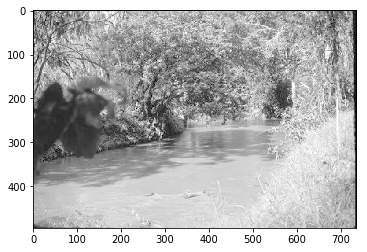

In [193]:
plt.imshow(x, cmap='gray')
plt.show()
plt.imshow(img_full,cmap='gray')
plt.show()

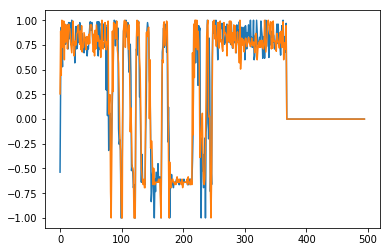

In [200]:
plt.plot(x[:,368])
plt.plot(x[:,369])
#plt.plot(x[:,370])
plt.show()

In [205]:
r = 20
p = 0.8
extend = 20
x = np.c_[img, np.empty([m, extend], dtype=img.dtype)]

for j in range(n,n+extend):
    #col = np.empty(n)
    for i in range(n):
        w = x[max(i-r//2, 0) : min(i+r//2, m-1) , j-r:j]
        corr = correlate(x[:,:j], w)
        x[i,j] = np.random.choice(x[:,:j][(corr+2e-6)/(corr.max()+1e-6) > p])

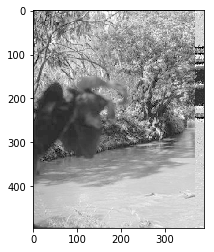

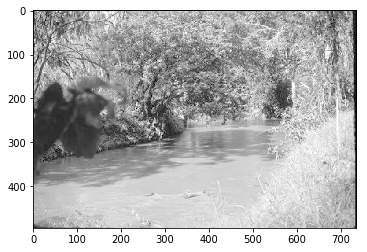

In [206]:
plt.imshow(x, cmap='gray')
plt.show()
plt.imshow(img_full,cmap='gray')
plt.show()

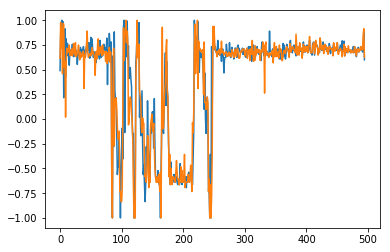

In [207]:
plt.plot(x[:,368])
plt.plot(x[:,369])
#plt.plot(x[:,370])
plt.show()

In [203]:
i,j,x.shape

(0, 370, (495, 388))

In [204]:
max(i-r//2, 0) , min(i+r//2, m-1) , j-r,j

(0, 10, 350, 370)

(array([2.2000e+01, 2.3500e+02, 3.5850e+03, 4.4581e+04, 3.6629e+04,
        3.9201e+04, 2.5069e+04, 1.7253e+04, 1.5251e+04, 3.3400e+02]),
 array([-9.68864283, -8.05303806, -6.41743329, -4.78182853, -3.14622376,
        -1.51061899,  0.12498577,  1.76059054,  3.39619531,  5.03180008,
         6.66740484]),
 <a list of 10 Patch objects>)

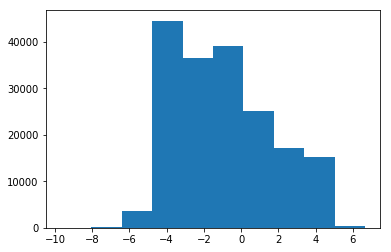

In [154]:
plt.hist(correlate(img, w).ravel())

In [73]:
np.prod(w.shape)

100

In [75]:
img_patch = np.empty(img.shape+(100,))
img_patch.shape

(495, 368, 100)

In [89]:
def distance_python(img, img_m, img_n, img_left, img_top, di, dj, win, win_m, win_n, out, out_m, out_n):
    # 从img 的img_left,img_top往右往下扫描，每次以其为中心，以di,dj为初始偏移，以di+win_m,dj+win_n为末尾偏移，匹配img
    # 中以i+img_left,j_right为中心的图与win的图的所有像素，计算其平方距离和。然后写入out数组的out[i,j]项中
    for i in range(out_m):
        for j in range(out_n):
            s = 0.
            for ii in range(win_m):
                for jj in range(win_n):
                    img_i = i+ii+img_left+di
                    img_j = j+jj+img_top+dj
                    s += (img[img_i,img_j] - win[ii,jj])**2
            out[i,j] = s


In [90]:
''' Too slow
out = np.empty_like(img[10:-10,10:-10])
distance_python(img, img.shape[0], img.shape[1], 10, 10, -10, -10, w, w.shape[0], w.shape[1], out, out.shape[0], out.shape[1])
'''
out = np.empty_like(img[10:-10,10:-10])
distance_python(img, img.shape[0], img.shape[1], 10, 10, -10, -10, w, w.shape[0], w.shape[1], out, out.shape[0], out.shape[1])


In [94]:
%%time
out = np.empty_like(img[100:200,100:200])
distance_python(img, img.shape[0], img.shape[1], 10, 10, -10, -10, w, w.shape[0], w.shape[1], out, out.shape[0], out.shape[1])


Wall time: 710 ms


In [98]:
%load_ext cython

In [104]:
%%cython --annotate

cimport numpy as np
cimport cython

import numpy as np

def distance_cython(double[:,:] img, int img_m, int img_n, int img_left, int img_top, int di, int dj, 
                    double[:,:] win, int win_m, int win_n, double[:,:] out, int out_m, int out_n):
    cdef float s
    cdef int i,j,ii,jj,img_i,img_j
    #s=0.0
    for i in range(out_m):
        for j in range(out_n):
            s = 0.
            for ii in range(win_m):
                for jj in range(win_n):
                    img_i = i+ii+img_left+di
                    img_j = j+jj+img_top+dj
                    s += (img[img_i,img_j] - win[ii,jj])**2
            out[i,j] = s


(10, 10)

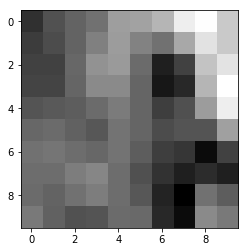

In [124]:
w = img[m//2-r//2 : m//2+r//2 , n//2:n//2+r]
plt.imshow(w, cmap='gray')
w.shape

In [125]:
%%time
out = np.empty_like(img[10:-10,10:-10])
distance_cython(img, img.shape[0], img.shape[1], 10, 10, -10, -10, w, w.shape[0], w.shape[1], out, out.shape[0], out.shape[1])


Wall time: 556 ms


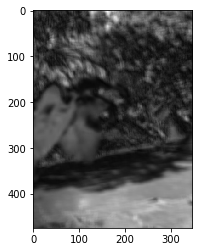

In [126]:
plt.imshow(out, cmap='gray')

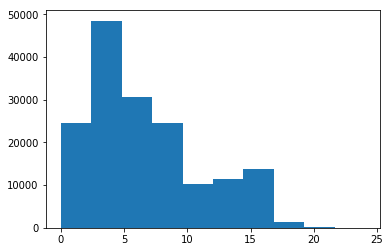

In [128]:
plt.hist(out.ravel())
plt.show()

(10, 10)

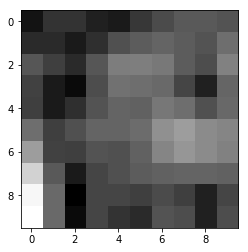

In [129]:
w = img[m//2-r//2 : m//2+r//2 , n//2+100:n//2+100+r]
plt.imshow(w, cmap='gray')
w.shape

In [130]:
%%time
out = np.empty_like(img[10:-10,10:-10])
distance_cython(img, img.shape[0], img.shape[1], 10, 10, -10, -10, w, w.shape[0], w.shape[1], out, out.shape[0], out.shape[1])


Wall time: 541 ms


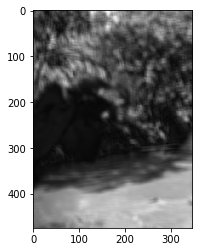

In [131]:
plt.imshow(out, cmap='gray')

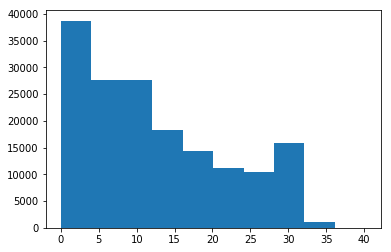

In [133]:
plt.hist(out.ravel())
plt.show()